In [118]:
import numpy as np
import scipy as spy
import scipy.integrate as integrate
import scipy.special as special
from sympy import *
import matplotlib.pyplot as plt
# from py_functions import getalpha0

In [119]:
## Model Constants
Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
perm0 = 8.85418782e-12#[m-3kg-1s4A2]
permr = 2.2 # for BOPP
Eb = 700e6 #[V/m] the breakdown strength of BOPP
w = 0.12 #[m] from original kellaris paper
t = 21e-6 #[m] Bopp thickness used in initial designs
#k = 1000000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
Eper = 0.6 # Percentage of electrode coverage
Va = 10000 # Actuation voltage
N = 1

In [120]:
## Swept constants
#Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
E = Va/(2*t)
#Eper = np.linspace(0,1,0.01)

## model start
#Lambda for force
lamb = Va**2*perm0*permr*w/(4*t)

# Electrode length
Le = Lp*Eper

#optimal fill eqn based on electrode coverage ratio
# !!! MIGHT NOT WORK WITH ARRAY !!!
alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
y = 0.01 # intial guess of angle
it = 0.0001 # iteration
scale = 1.6/it # how many possible
end = int(scale) # int for loop
for i in range(0,end): # over scale
    
    func = (y-sin(y)*cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
    
    if func >= 0: # root is transition from negative to positive in this case
        alp0 = y - it # previous value before sign flip returned       
        break #root found, stop
    else:
        y += it #move to next guess
        continue


#Height
h = Lp*(sin(alp0)/alp0) # Height [m]

#Area w/ restraints 
# !!! MIGHT NOT WORK WITH ARRAY !!!
A = (Lp - Le)**2 /np.pi # Area [m2]

#Blocking force
Fb = (lamb)*(cos(alp0)/(1-cos(alp0)))

Lpf = Lp - Le # Fully Deformed pouch length 

xmax = h - (Lpf*(sin(alpf)/alpf)) - Le # max displacement

alp = np.linspace(alp0,alpf,10000) #sweep alpha and SET RESOLUTION

# Blocks of lp(alp) eqn sweep
lpnum = 2*A*np.square(alp)
lpdom = (alp - np.sin(alp)*np.cos(alp))
lp2 = lpnum/lpdom
lp = lp2**0.5
lp[0] = Lp # Removes unphysical discretisation error

# electrode length sweep
le = Lp - lp 

# displacement sweep
lpmp = np.sin(alp)/alp # lp multiplier in x
lplpmp = lp*lpmp
X = h - lplpmp - le

# Load of spring
#P = k*X

# Force output of actuator
F = lamb*(np.cos(alp)/(1-np.cos(alp)))*N

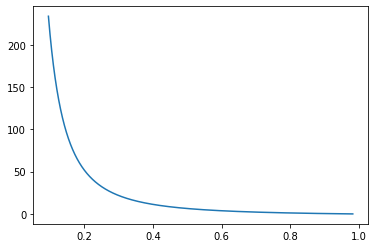

In [121]:
fig, ax = plt.subplots() 
ax.plot(alp/1.6,F)
#ax.plot(alp,P)

In [122]:
# x = X[0:i] # Physically relevant values for integration 
# p = P[0:i]
# f = F[0:i]
# # Energy in spring
# Usee = spy.integrate.trapezoid(p,x)
# print(Usee)
# # Energy output of actuator
# Uact = spy.integrate.trapezoid(f,x)

In [123]:
# Array scaling
# n = 1 # Numbver of fibres
# F = F*n # Scale force in array

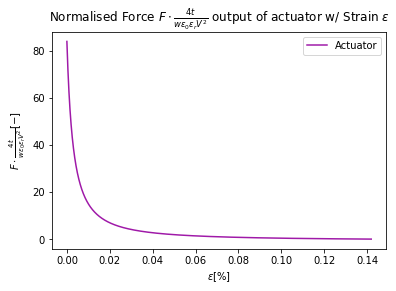

In [124]:
for i in range(len(F)):
    if F[i] <= P[i]:
        y2 = F[i]
        break
    else:
        continue
NF=F/lamb
NP=P/lamb
strain = X/h
fig, ax = plt.subplots() 
ax.plot(strain,NF, color='#9F19A8', label='Actuator')
plt.xlabel(r"$\epsilon [\%]$")
plt.ylabel(r"$F\cdot\frac{4t}{w\epsilon_0\epsilon_r V^2}$"r"$[-]$")
plt.title(r"Normalised Force "r"$F\cdot\frac{4t}{w\epsilon_0\epsilon_r V^2}$" r" output of actuator w/ Strain "r"$\epsilon$")
leg = plt.legend(loc = 'upper right')
#ax.plot(strain,NP)




In [125]:
for i in range(len(F)):
    if F[i] <= P[i]:
        cut = i
        print(X[i])
        break
    else:
        continue

8.60738459838480e-5


In [126]:
for i in range(len(X)):
        if F[i] <= P[i]:
            cut = i
            for j in range(i+1,len(X)):
                F[j] = float("NaN")
                P[j] = float("NaN")
        else:
            continue


In [127]:
x = X[0:cut] # Physically relevant values for integration 

p = P[0:cut]

f = F[0:cut]

# Energy in spring
Usee = spy.integrate.trapezoid(p,x)

# Energy output of actuator
Uact = spy.integrate.trapezoid(f,x)

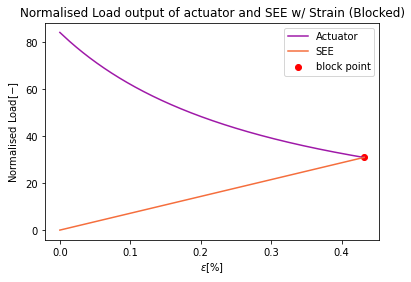

In [128]:
strain = X/h*100
NF=F/lamb
NP=P/lamb
fig, ax = plt.subplots()
ax.scatter(strain[cut-1],NP[cut-1],color='red',label='block point') 
ax.plot(strain,NF, color='#9F19A8', label='Actuator')
ax.plot(strain,NP,color='#F56E3D', label='SEE')
# plt.annotate("Block Point", (strain[cut],P[cut]), (strain[cut]-0.3,P[cut]+2))
plt.xlabel(r"$\epsilon [\%]$")
plt.ylabel(r"Normalised Load"r"$[-]$")
plt.title(r"Normalised Load output of actuator and SEE w/ Strain (Blocked)")
leg = plt.legend(loc = 'upper right')



In [129]:
SEEeff = Usee/Uact
print(SEEeff)
print(Usee)
print(Uact)

0.308661918773790
0.00369232678070710
0.0119623657993687


In [130]:
## Bending
# Define new constants
# https://www.m-petfilm.de/en/service/comparative-data-for-plastic-films/ for youngs mods

Ymt = 4.5e9 # youngs modulus in machined direction N/m
Ymm = 2.5e9 # yong mod in trans direction N/m 
nu = 0.33 # Poissons ratio

D = ((t**3)*w*Ymm)/(12*(1-nu)**2) # Bending stiffness
k = (2*alp)/lp # Curvature of membrane

Ub = D*k**2*lp # Bending Energy

# Force w/ Bending
Fwb = lamb*(np.cos(alp)/(1-np.cos(alp))) + 2*D*(alp-np.sin(alp)*np.cos(alp)/A) * (np.cos(alp)/(1-np.cos(alp))) * (1+(2*alp*np.tan(alp)**2)/(alp-np.tan(alp)))




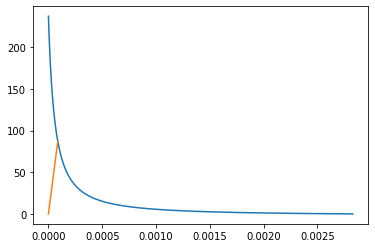

In [131]:
fig, ax = plt.subplots() 
ax.plot(X,Fwb)
ax.plot(X,P)